<a href="https://colab.research.google.com/github/jack-baxter/AAI521-G6-Final/blob/main/Group6_AAI_521_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup and Drive Mounting

In [1]:
# Install necessary deep learning and utility libraries
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib seaborn Pillow

from google.colab import drive
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

print("Environment setup complete. Drive mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Environment setup complete. Drive mounted.


Data Acquisition, Cleaning, and Stratified Split

In [2]:
# Base directory
BASE_DIR = '/content/drive/MyDrive/ELPV_SOLAR_DATA/'

def create_binary_classification_labels(root_dir):

    data_list = []

    # Iterate through the pre-split directories (train, test, valid)
    for split_dir in ['train', 'test', 'valid']:
        img_dir = os.path.join(root_dir, split_dir, 'images')
        label_dir = os.path.join(root_dir, split_dir, 'labels')

        if not os.path.isdir(img_dir) or not os.path.isdir(label_dir):
            continue

        # Iterate through all image files to find corresponding labels
        for img_file in os.listdir(img_dir):
            name, ext = os.path.splitext(img_file)
            if ext.lower() not in ('.png', '.jpg', '.jpeg'):
                continue

            txt_file = os.path.join(label_dir, name + '.txt')


            label = 1 if (os.path.exists(txt_file) and os.path.getsize(txt_file) > 0) else 0

            data_list.append({
                'image_path': os.path.join(img_dir, img_file),
                'label': label
            })

    return pd.DataFrame(data_list)


# Load all data and classification labels
df_full = create_binary_classification_labels(BASE_DIR)

if df_full.empty:
    raise SystemExit("ERROR: No images found.")

print("Total images:", len(df_full))
print("Initial Class Counts:\n", df_full['label'].value_counts())

# Perform a full stratified 80/10/10 split (crucial for severe imbalance)

df_train, df_temp = train_test_split(
    df_full, test_size=0.2, stratify=df_full['label'], random_state=42
)

df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42
)

print("\nFinal Stratified Split Sizes:")
print(f"Train Samples: {len(df_train)}")
print(f"Val Samples: {len(df_val)}")
print(f"Test Samples: {len(df_test)}")
print(f"Test Set Minority (Label 0) Count: {df_test['label'].value_counts().get(0, 0)}")

Total images: 7435
Initial Class Counts:
 label
1    7332
0     103
Name: count, dtype: int64

Final Stratified Split Sizes:
Train Samples: 5948
Val Samples: 743
Test Samples: 744
Test Set Minority (Label 0) Count: 11


Exploratory Data Analysis (EDA)

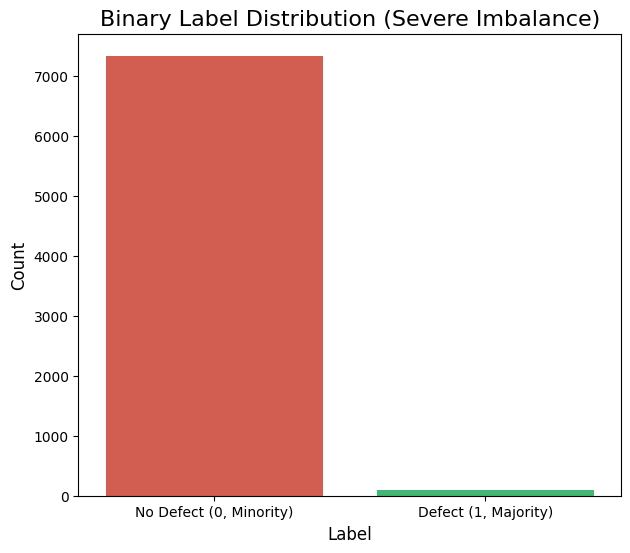


Running Image Path Integrity Check on Training Samples:


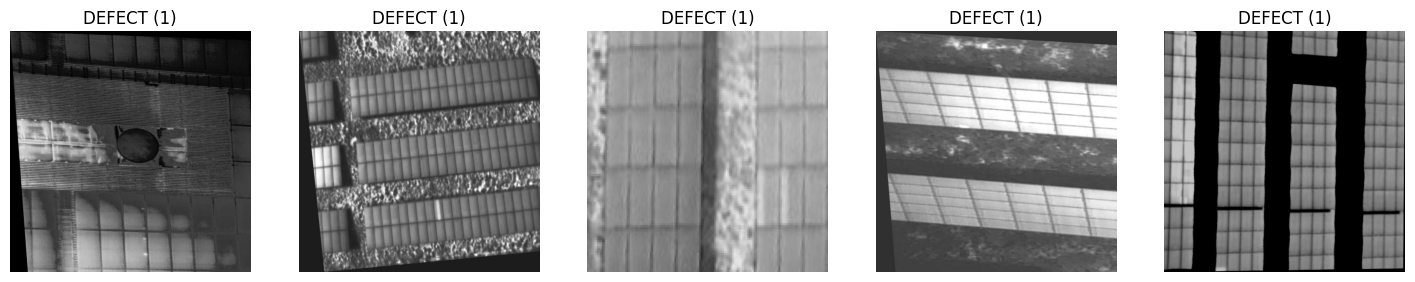

In [3]:
# Ensure labels are string type for categorical plotting
df_full['label_str'] = df_full['label'].astype(str)

# Chart 1: Class Distribution Visualization (Visually confirming severe imbalance)
plt.figure(figsize=(7,6))
sns.countplot(
    x='label_str',
    hue='label_str',
    data=df_full,
    palette={'0': '#2ecc71', '1': '#e74c3c'},
    legend=False
)
plt.title("Binary Label Distribution (Severe Imbalance)", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['No Defect (0, Minority)', 'Defect (1, Majority)'])
plt.show()

# Chart 2: Sample Image Check (Verification of Image Paths)
def show_samples(df, n=5):
    """Loads and displays sample images from the DataFrame."""
    sample = df.sample(n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(18,5))

    for i, (_, row) in enumerate(sample.iterrows()):
        try:
            img = Image.open(row['image_path']).convert('RGB')
            axes[i].imshow(img)
            label_text = "DEFECT (1)" if row['label']==1 else "NO DEFECT (0)"
            axes[i].set_title(label_text)
            axes[i].axis('off')
        except Exception:
            axes[i].set_title("ERROR: Image Load Failed", color='red')
            axes[i].axis('off')

    plt.show() # The function ends here!

print("\nRunning Image Path Integrity Check on Training Samples:")
show_samples(df_train) # This is the single, correct call.

PyTorch Data Pipeline

In [4]:
# Image standardization parameters
image_size = 256
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data Augmentation Transforms (Heavy Augmentations applied to Training Data)
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test/Validation Transforms (Deterministic for evaluation)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


class PVPanelDataset(Dataset):
    """Custom Dataset with robustness for loading images from the DataFrame paths."""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        try:
            # Robust image loading with error handling
            img = Image.open(row['image_path']).convert('RGB')

        except Exception:
            # If the image is corrupt, return None; filtered by the collate_fn
            return None

        img = self.transform(img) if self.transform else img
        # Ensure label is a long tensor for CrossEntropyLoss
        label = torch.tensor(row['label'], dtype=torch.long)
        return img, label

def collate_remove_none(batch):
    """Custom collate function to filter out None (corrupt) samples."""
    batch = [x for x in batch if x is not None]
    if not batch: return None, None
    return torch.utils.data.dataloader.default_collate(batch)

# DataLoader Initialization

num_workers = 2
batch_size = 32

train_loader = DataLoader(PVPanelDataset(df_train, train_transform),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=False, collate_fn=collate_remove_none)

val_loader = DataLoader(PVPanelDataset(df_val, test_transform),
                        batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=False, collate_fn=collate_remove_none)

test_loader = DataLoader(PVPanelDataset(df_test, test_transform),
                         batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=False, collate_fn=collate_remove_none)

print("Dataloaders ready ")

Dataloaders ready 
